In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

import jax.numpy as jnp

import candas as can
from candas.test import QuantStudio
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

In [3]:
def get_lg10_Q_fun(data):
    K = data.groupby("lg10_Copies")["K"].mean()
    F0_lg = data.groupby("lg10_Copies")["F0_lg"].mean()
    lg_Q = (
        (F0_lg - np.log10(K) - (7 + 5 - np.log10(6.022e23)))
        .rename("mean")
        .reset_index()
    )
    lg_Q_fun = np.poly1d(np.polyfit(lg_Q.lg10_Copies, lg_Q["mean"], 1))
    return lg_Q_fun

import jax.numpy as jnp

In [4]:
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets.pkl")
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets_220528.pkl")
ps = ps[ps.Metric == 'mean']

In [5]:
width = 3.65
height = 2.0  #1.109  #0.829
figsize = (width, height)
ticklabelsize = 6
labelsize = 6
titlesize = 8
spotsize = 6**2
xticks = [2, 4, 6, 8]

plt.rcParams.update({
    'figure.figsize': figsize,
    'figure.dpi': 300,
    'font.size': labelsize,
    'axes.labelsize': labelsize,
    'xtick.labelsize': ticklabelsize,
    'ytick.labelsize': ticklabelsize,
    'xtick.major.size': 1.5,
    'ytick.major.size': 1.5,
    'xtick.major.width': 0.6,
    'ytick.major.width': 0.6,
    'legend.fontsize': labelsize,
    'axes.titlesize': titlesize,
#     'lines.linewidth': 0.5,
    'axes.linewidth': 0.5,
})

palette = sns.diverging_palette(20, 220, as_cmap=True)

mar_l = 0.275
mar_r = 0.04
mar_t = 0.14
mar_b = 0.5

In [6]:
def format_figure(fig, axs):
    fig.set_size_inches(figsize)

    plt.setp(
        axs,
        ylim=[-1.1, 1.1],
        xticks=xticks,
        xlim=[1, 9],
        xlabel="",
        xticklabels="",
        # title="",
    )
    for i, ax in enumerate(axs.flat):
        ax.tick_params(axis="both", labelsize=ticklabelsize, length=1.5, width=0.6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
        ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
        if i > 0:
            ax.yaxis.set_tick_params(length=0)
        if ax not in axs[-1, :]:
            ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)
        
    plt.setp(
        axs[:,0],
        ylabel='FAM-HEX',
    )

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
    )

# Import Data

In [7]:
cmax = 40

JG063A = QuantStudio(data_pth / "JG063A Competitor Concentration Sweep.xlsx", "JG063A")
JG063B = QuantStudio(
    data_pth / "JG063B Competitor concentration sweep 2.xlsx", "JG063B"
)
JG063I = QuantStudio(data_pth / "JG063I Primer Probe Sweep 5 logs.xlsx", "JG063I")
JG034 = QuantStudio(data_pth / "JG034 TMCC1 Gen2 Competitors - 59C v3.xlsx", "JG034")

for qs in [JG063A, JG063B, JG063I, JG034]:
    print(f"Processing {qs.experiment}")
    (qs.import_data().format_reactions().index_reactions().subtract_background())

    qs.reactions.data.drop(
        qs.reactions.data.index[qs.reactions.data.Well == 281], inplace=True
    )

    (qs.normalize_reactions(cmax=cmax, method="max").invert_fluorophore("HEX"))

    if qs.experiment == "JG063I":
        primerprobe = (
            qs.reactions.data.Sample.str.split(" ", expand=True)[0]
            .str.split("+", expand=True)
            .rename(columns={0: "Primer nM", 1: "Probe nM"})
        )

        qs.reactions.data = qs.reactions.data.merge(
            primerprobe, left_index=True, right_index=True
        )
    elif qs.experiment == "JG034":
        qs.reactions.data.Target = qs.reactions.data.Target.str.split(" - ").map(
            lambda row: row[0]
        )

    # Denote competitor and WT concentration in each well
    syn_copies = qs.reactions.wide.query('Reporter=="HEX"')[
        ["Well", "lg10_Copies"]
    ].rename(columns={"lg10_Copies": "SYN_Copies"})
    wt_copies = qs.reactions.wide.query('Reporter=="FAM"')[
        ["Well", "lg10_Copies"]
    ].rename(columns={"lg10_Copies": "WT_Copies"})
    qs.reactions.data = qs.reactions.data.merge(syn_copies, on="Well").merge(
        wt_copies, on="Well"
    )

    if qs.experiment in ["JG063A", "JG063B"]:
        qs.reactions.data = qs.reactions.data.assign(Target=qs.reactions.data.Sample)

    qs.reactions.neaten()
    qs.extract_endpoints(cmax=cmax, name="FAM-HEX", method="diff")

Processing JG063A
Processing JG063B
Processing JG063I
Processing JG034


In [8]:
wts = ["S056.4.12", "S056.4.12", "S044.13", "S056.4.12", "S044.13"]
targets = ["S056.4.3", "S056.4.1", "GC55", "S056.4.4", "GC15"]
target_codes = ["S056.4.3", "S056.4.1", "S044.14", "S056.4.4", "S044.9"]

In [9]:
endpoints = pd.concat(
    [
        (
            JG063A.endpoints[
                (
                    (JG063A.endpoints.SYN_Copies == 5)
                    & (JG063A.endpoints.Sample == "S056.4.2_vs_S056.4.12")
                )
                | (
                    (JG063A.endpoints.SYN_Copies == 5)
                    & (JG063A.endpoints.Sample == "S056.4.4_vs_S056.4.12")
                )
            ].assign(Target=lambda df: df.Target.str.split("_").str[0])
        ),
        (
            JG063B.endpoints[
                (
                    (JG063B.endpoints.SYN_Copies == 4)
                    & (JG063B.endpoints.Sample == "S056.4.1_vs_S056.4.12")
                )
                | (
                    (JG063B.endpoints.SYN_Copies == 6)
                    & (JG063B.endpoints.Sample == "S056.4.3_vs_S056.4.12")
                )
            ].assign(Target=lambda df: df.Target.str.split("_").str[0])
        ),
        JG034.endpoints,
    ]
)

endpoints = endpoints[endpoints["Target"].isin(targets) & (endpoints["WT_Copies"] > 1)]

for target in targets:
    this_data = endpoints["Target"] == target
    mn = endpoints.loc[this_data, "FAM-HEX"].min()
    mx = endpoints.loc[this_data, "FAM-HEX"].max()
    endpoints.loc[this_data, "FAM-HEX"] = (endpoints.loc[this_data, "FAM-HEX"] - mn) / (
        mx - mn
    ) * 2 - 1


In [10]:
target = np.array([[-1, +1]])
competitor = np.array([[-1, +1]])

positive_labels = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

rxn_b = can.models.CAN(
    target,
    competitor,
    positive_labels,
    INT_names=["WT"],
    EXT_names=["REF"],
    label_names=["H", "F"],
)

rxn_b.n_cycles = 50
rxn_b.compile()

rxn_b.norm.nM = 100

def sym_bipartite(
    ref_lgQ,
    ref_rate=None,
    wt_rate=0.9,
    wt_pts = None,
    wt_start=2,
    wt_end=8,
    n_points=100,
    ref_drift=0,
    wt_drift=0,
    wt_lgQ_fun=None,
    ref_lgQ_fun=None,
    wt=None,
    ref=None,
):

    if wt is not None:
        wt_data = ps[ps.Target == wt]
        wt_rate = wt_data["r"].mean()
        wt_drift = wt_data["m"].mean()
        wt_lgQ_fun = get_lg10_Q_fun(wt_data)
    
    if wt_lgQ_fun is None:
        wt_lgQ_fun = lambda x: x  # identity function if not provided
        
    if ref is not None:
        ref_data = ps[ps.Target == ref]
        ref_rate = ref_data["r"].mean()
        ref_drift = ref_data["m"].mean()
        ref_lgQ_fun = get_lg10_Q_fun(ref_data)
    
    if ref_lgQ_fun is None:
        ref_lgQ_fun = lambda x: x  # identity function if not provided
        
    rxn_b.oligo("WT").rate = wt_rate
    rxn_b.oligo("WT").drift = wt_drift
    
    rxn_b.oligo("REF").rate = ref_rate
    rxn_b.oligo("REF").drift = ref_drift

    rxn_b.oligo("REF").copies = 10**ref_lgQ_fun(ref_lgQ)

    if wt_pts is not None:
        wt_lgQ = wt_pts
    else:
        wt_lgQ = np.linspace(wt_start, wt_end, n_points)
        
    arrays = [wt_lgQ_fun(wt_lgQ)]
    grids = jnp.meshgrid(*arrays)
    pts = jnp.vstack([grid.ravel() for grid in grids]).T

    rxn_b.sweep_setup = arrays, grids, pts, rxn_b.INT_idxs
    sol = rxn_b.solution_sweep()
    return wt_lgQ, sol

In [11]:
from matplotlib import cm
from matplotlib import colormaps

rmse_norm = cm.colors.Normalize(vmin=0.029902191266630403, vmax=0.5404995294703315)

cmap = colormaps["flare"]

# Competitor Concentration

Saving fig_S8A__tangible_urchin in /home/john/projects/can-manuscript/fig_S8__dark_kudu/graphics: [.svg] [.png] done


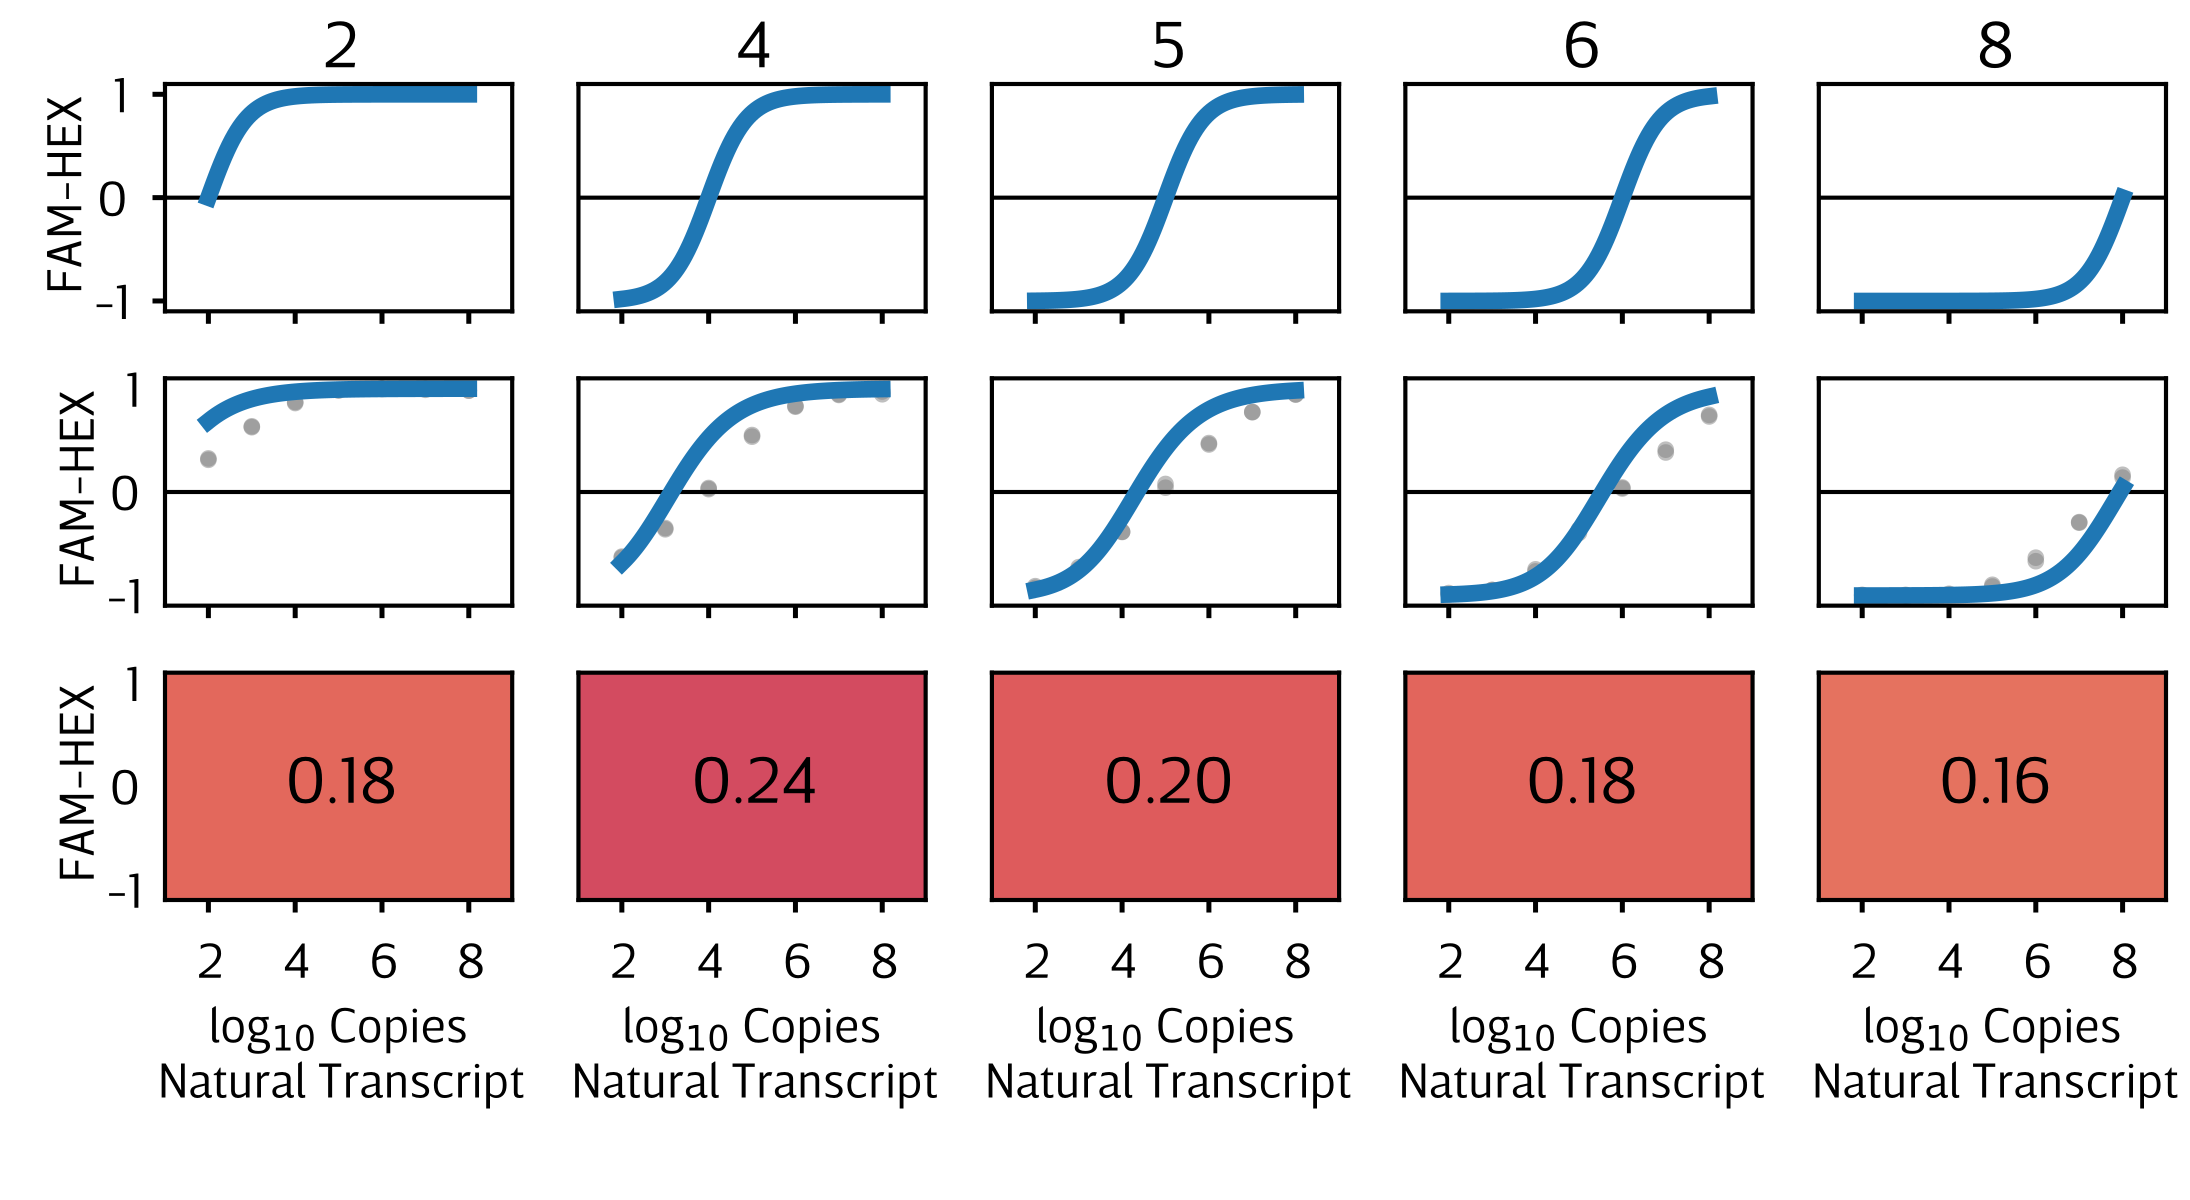

In [12]:
from copy import copy

JG063A_lim = copy(JG063A)

JG063A_lim.reactions.data = JG063A_lim.reactions.data[
    JG063A_lim.reactions.data["Sample"] == "S056.4.2_vs_S056.4.12"
]

(
    JG063A_lim.invert_fluorophore("HEX")
    .normalize_reactions(cmax=cmax, method="min-max")
    .invert_fluorophore("HEX")
    .extract_endpoints(cmax=cmax, name="FAM-HEX", method="bipolar")
)

this = JG063A_lim.endpoints[
    (JG063A_lim.endpoints["Sample"] == "S056.4.2_vs_S056.4.12")
    & (JG063A_lim.endpoints["WT_Copies"] > 1)
]

fig_conc, axs_conc = plt.subplots(3, 5, figsize=figsize, sharex=True, sharey=True)
rmse_conc = []

rxn_b.primer_nMs = [100, 100]

for ax, ref_lgQ in zip(axs_conc[0], [2, 4, 5, 6, 8]):
    wt_lgQ, sol = sym_bipartite(ref_lgQ=ref_lgQ, ref_rate=0.9, wt_rate=0.9)
    ax.plot(wt_lgQ, sol, lw=2)
    ax.set_title(ref_lgQ, fontsize=titlesize, pad=2)

for ax, ref_lgQ in zip(axs_conc[1], [2, 4, 5, 6, 8]):

    wt_lgQ, sol = sym_bipartite(wt="S056.4.12", ref="S056.4.2", ref_lgQ=ref_lgQ)
    ax.plot(wt_lgQ, sol, lw=2)
    # ax.set_title(ref_lgQ, fontsize=titlesize, pad=2)

    wt_pts = this[this.SYN_Copies == ref_lgQ].lg10_Copies.values
    endpts = this[this.SYN_Copies == ref_lgQ]["FAM-HEX"].values
    
    ax.scatter(
        wt_pts,
        endpts,
        s=4,
        color="grey",
        edgecolor="none",
        alpha=0.5,
        zorder=-10,
    )
    
    wt_lgQ, sol = sym_bipartite(
        wt="S056.4.12", ref="S056.4.2", ref_lgQ=ref_lgQ, wt_pts=wt_pts
    )
    rmse = np.sqrt(
        np.mean((sol - endpts) ** 2)
    )
    rmse_conc.append(rmse)
    
for ax, rmse in zip(axs_conc[2], rmse_conc):
    ax.set_facecolor(cmap(rmse_norm(rmse)))
    ax.annotate(
        f"{rmse:.2f}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        fontsize=titlesize,
        ha="center",
        va="center",
    )

# plt.suptitle("Competitor Concentration (log10 copies)", fontsize=labelsize + 4, y=1.0)

plt.tight_layout()
format_figure(fig_conc, axs_conc)


plt.setp(axs_conc, xticks=xticks, xticklabels=xticks)
for ax in axs_conc[2]:
    ax.set_xlabel("log$_{10}$ Copies\nNatural Transcript")

savefig(plt.gcf(), "tangible_urchin", transparent_svg=False)

# Competitor Design

Saving fig_S8B__invisible_parrot in /home/john/projects/can-manuscript/fig_S8__dark_kudu/graphics: [.svg] [.png] done


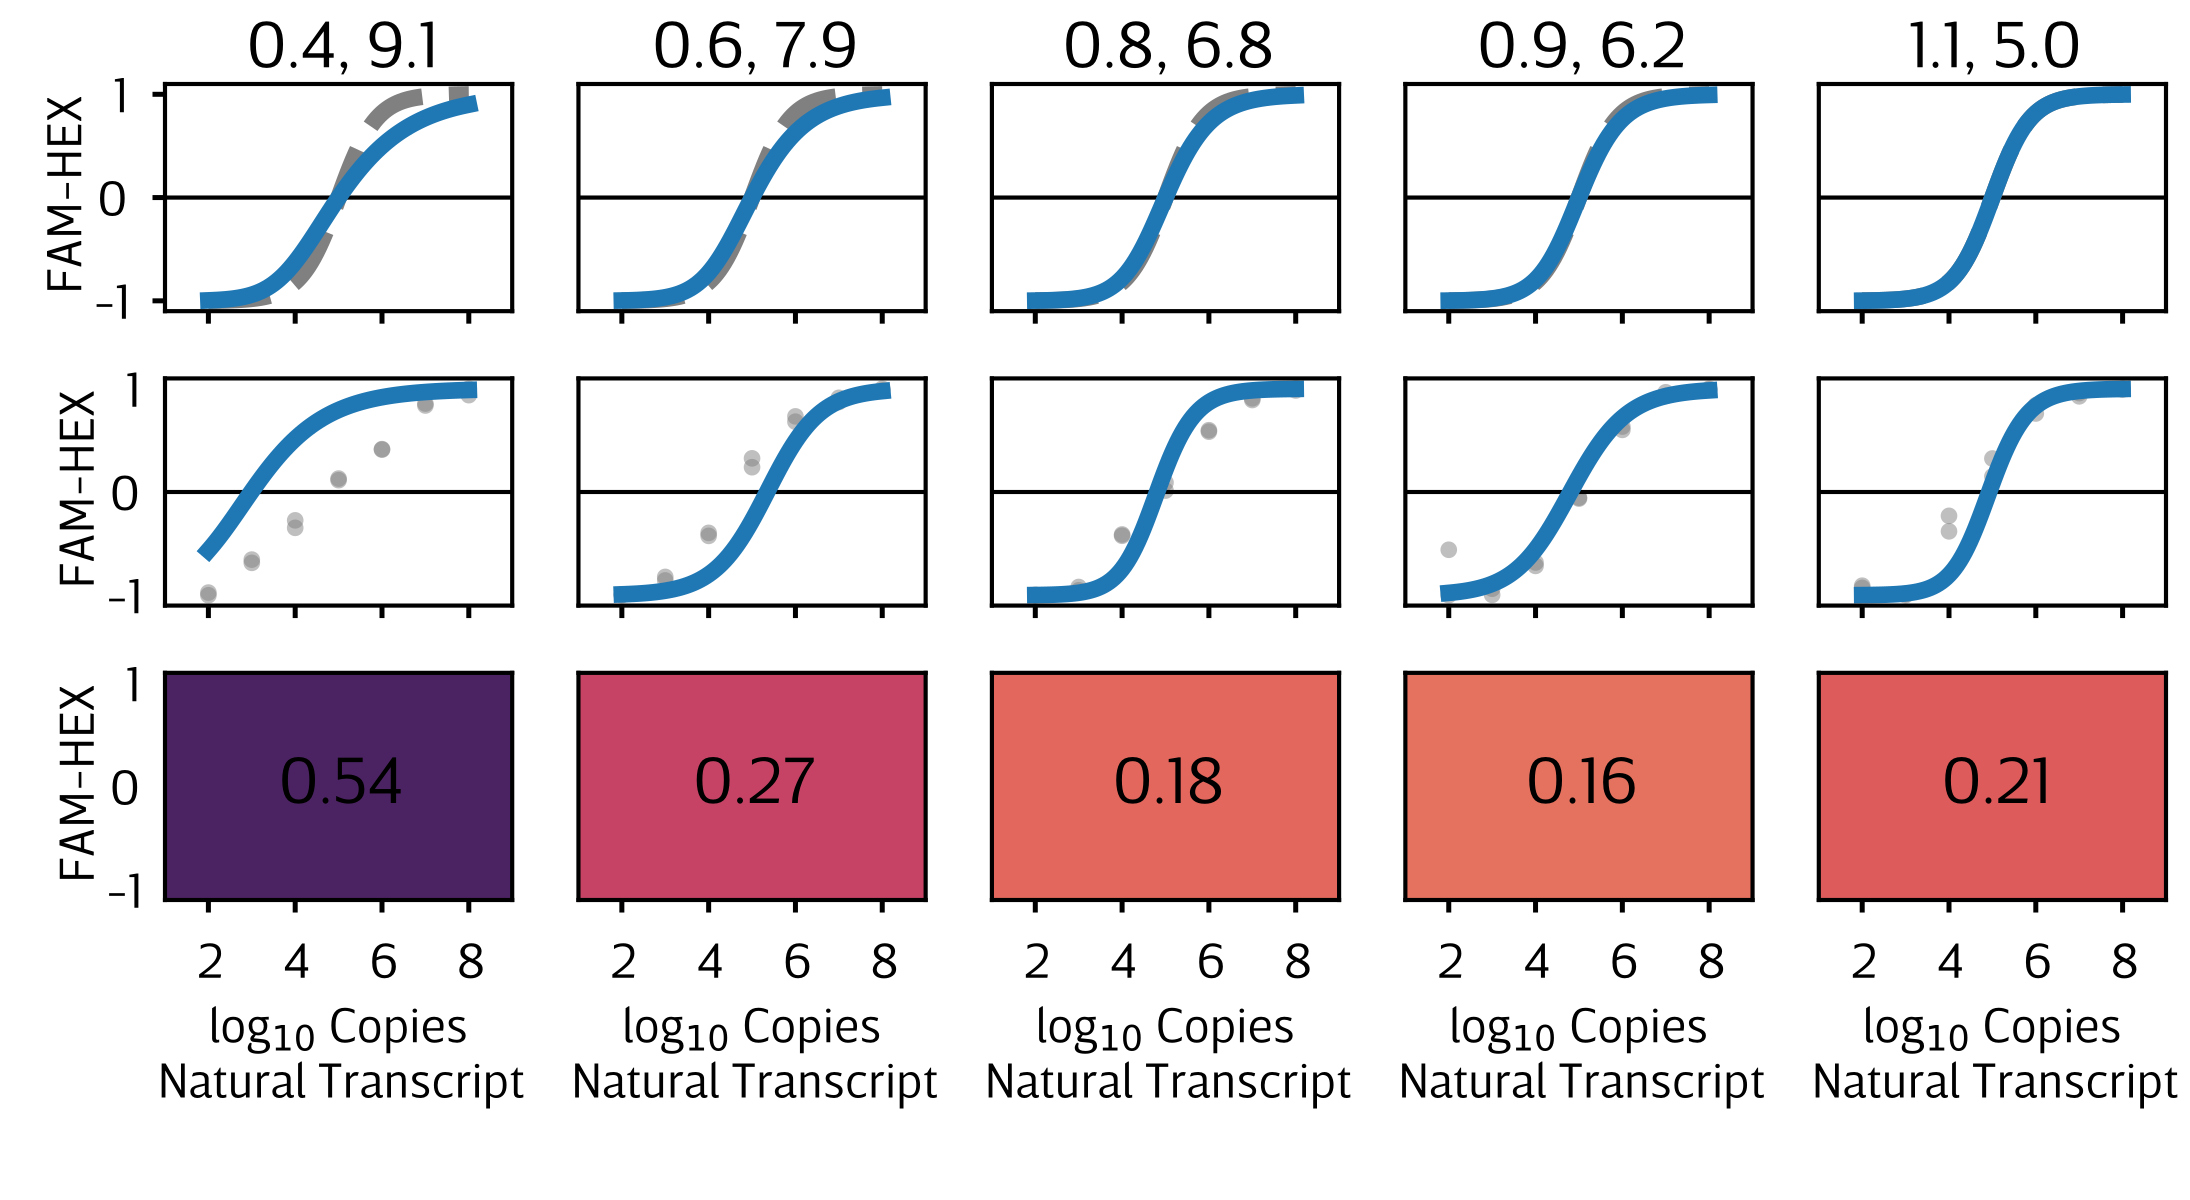

In [13]:
fig_dsgn, axs_dsgn = plt.subplots(3, 5, figsize=figsize, sharex=True, sharey=True)

ref_lg = 5.0
rxn_b.norm.nM = 100
rxn_b.primer_nMs = [100, 100]

def ref_lgQ_loss(ref_lgQ, ref_rate=0.9, wt_rate=1.1, wt_lgQ=5.0):

    rxn_b.oligo("WT").rate = wt_rate
    rxn_b.oligo("REF").rate = ref_rate
    rxn_b.oligo("WT").drift = 0
    rxn_b.oligo("REF").drift = 0
    rxn_b.oligo("REF").copies = 10**ref_lgQ
    rxn_b.oligo("WT").copies = 10**wt_lgQ

    rxn_b.setup_solution_sweep(rng=[wt_lgQ, wt_lgQ], res=1)
    rxn_b.sweep_setup
    loss = np.array(rxn_b.solution_sweep())[0] ** 2

    return loss

from scipy.optimize import minimize_scalar

rmse_dsgn = []

_, mid_sol = wt_lgQ, sol = sym_bipartite(wt_rate=1.1, ref_rate=1.1, ref_lgQ=5.0)
for ax, rate, ref_lgQ in zip(axs_dsgn[0], [0.4, 0.6, 0.8, 0.9, 1.1], [6.5, 6.0, 5, 4, 3]):
    ref_lgQ = minimize_scalar(
        ref_lgQ_loss, args=(rate, 1.1), bounds=(-1, 11), method="bounded"
    ).x
    wt_lgQ, sol = sym_bipartite(wt_rate=1.1, ref_rate=rate, ref_lgQ=ref_lgQ)
    ax.plot(wt_lgQ, mid_sol, ls="--", color="gray", lw=2)
    ax.plot(wt_lgQ, sol, lw=2)
    ax.set_title(f"{rate}, {ref_lgQ:.1f}", fontsize=titlesize, pad=2)
    
for ax, target, code, wt in zip(axs_dsgn[1], targets, target_codes, wts):
    these_endpoints = endpoints[endpoints.Target == target]
    wt_pts = these_endpoints.WT_Copies.values
    endpts = these_endpoints["FAM-HEX"].values
    
    ax.scatter(
        wt_pts,
        endpts,
        s=4,
        color="grey",
        edgecolor="none",
        alpha=0.5,
        zorder=-10,
    )
    
    wt_lgQ, sol = sym_bipartite(
        wt=wt, ref=code, ref_lgQ=ref_lg
    )
    ax.plot(wt_lgQ, sol, lw=2)
    
    wt_lgQ, sol = sym_bipartite(
        wt=wt, ref=code, ref_lgQ=ref_lg, wt_pts=wt_pts
    )
    rmse = np.sqrt(
        np.mean((sol - endpts) ** 2)
    )
    rmse_dsgn.append(rmse)
    
for ax, rmse in zip(axs_dsgn[2], rmse_dsgn):
    ax.set_facecolor(cmap(rmse_norm(rmse)))
    ax.annotate(
        f"{rmse:.2f}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        fontsize=titlesize,
        ha="center",
        va="center",
    )

plt.tight_layout()
format_figure(fig_dsgn, axs_dsgn)

plt.setp(axs_dsgn, xticks=xticks, xticklabels=xticks)
for ax in axs_dsgn[2]:
    ax.set_xlabel("log$_{10}$ Copies\nNatural Transcript")
    
savefig(plt.gcf(), "invisible_parrot", transparent_svg=False)

# Primer Concentration

Saving fig_S8C__oblong_quetzal in /home/john/projects/can-manuscript/fig_S8__dark_kudu/graphics: [.svg] [.png] done


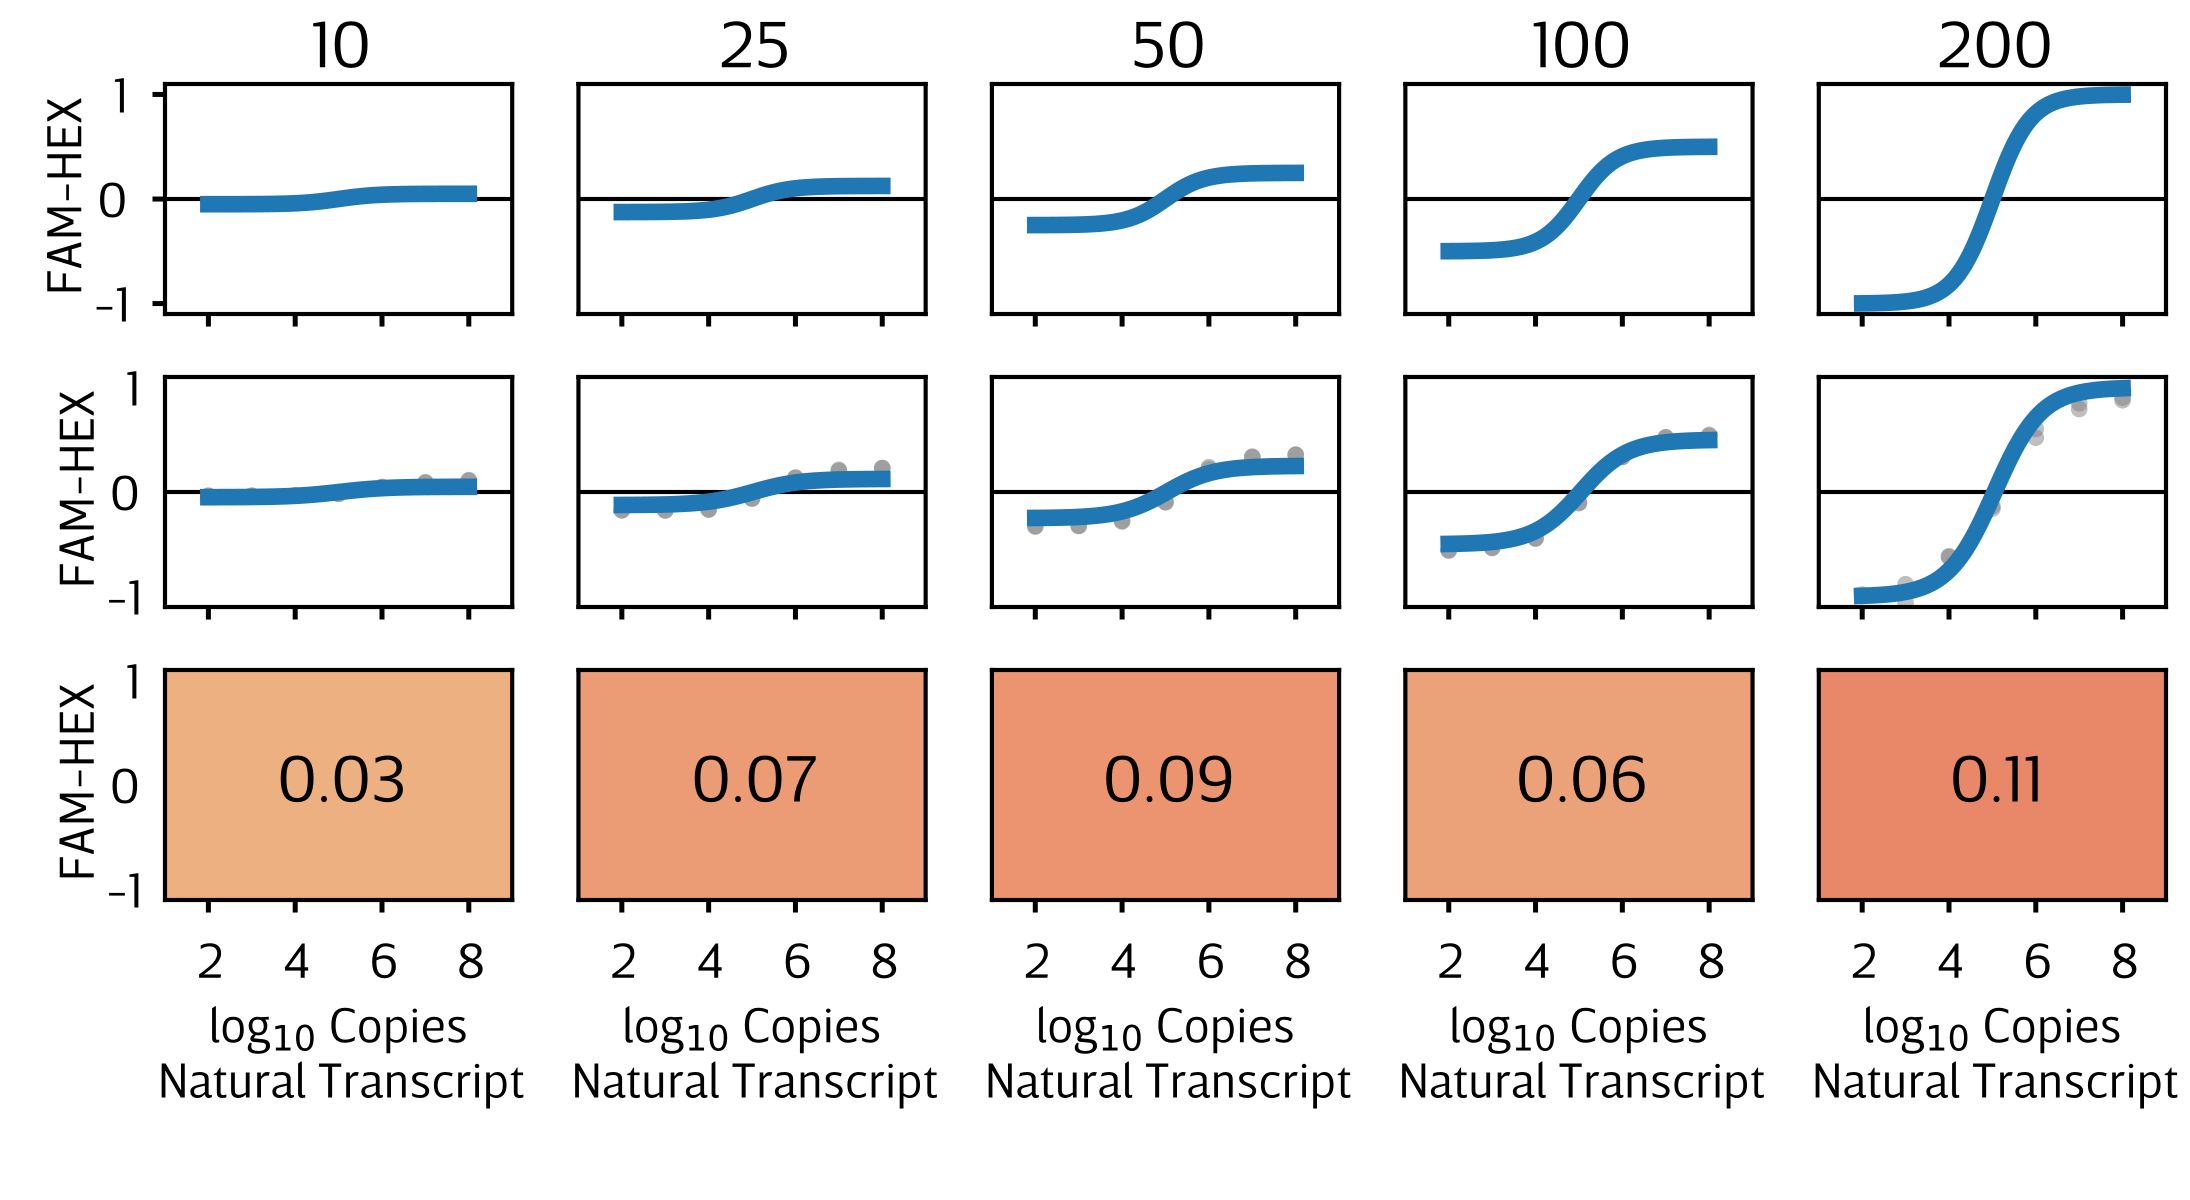

In [14]:
fig_prmr, axs_prmr = plt.subplots(3, 5, figsize=figsize, sharex=True, sharey=True)
# format_figure(fig, axs)
ref_lgQ = 5.0
ref_rate = 0.8
wt_rate = 0.8

this = JG063I.endpoints[
    (JG063I.endpoints["Probe nM"] == "200") & (JG063I.endpoints["WT_Copies"] > 1)
]

rmse_prmr = []

for ax, nM in zip(axs_prmr[0], [10, 25, 50, 100, 200]):
    rxn_b.primer_nMs = [nM, nM]
    wt_lgQ, sol = sym_bipartite(
        wt_rate=wt_rate,
        ref_rate=ref_rate,
        ref_lgQ=ref_lgQ,
    )
    ax.plot(wt_lgQ, sol / 2, lw=2)
    ax.set_title(nM, fontsize=titlesize, pad=2)
    # ax.set_xlim(1, 9)
    # ax.set_ylim(-1.1, 1.1)
    # ax.set_xticks([2, 4, 6, 8])
    # ax.set_xlabel("log$_{10}$ Copies\nNatural Transcript", fontsize=labelsize, labelpad=2)

for ax, nM in zip(axs_prmr[1], [10, 25, 50, 100, 200]):
    rxn_b.primer_nMs = [nM, nM]
    wt_lgQ, sol = sym_bipartite(
        wt="S056.1.12",
        ref="S056.1.1",
        ref_lgQ=5.0,
    )
    ax.plot(wt_lgQ, sol / 2, lw=2)

    wt_pts = this[this["Primer nM"] == str(nM)]['WT_Copies'].values
    endpts = this[this["Primer nM"] == str(nM)]["FAM-HEX"].values

    ax.scatter(
        wt_pts,
        endpts,
        s=4,
        color="grey",
        edgecolor="none",
        alpha=0.5,
        zorder=-10,
    )

    wt_lgQ, sol = sym_bipartite(
        wt="S056.1.12", ref="S056.1.1", ref_lgQ=5.0, wt_pts=wt_pts
    )
    rmse = np.sqrt(np.mean((sol/2 - endpts) ** 2))
    rmse_prmr.append(rmse)
    
for ax, rmse in zip(axs_prmr[2], rmse_prmr):
    ax.set_facecolor(cmap(rmse_norm(rmse)))
    ax.annotate(
        f"{rmse:.2f}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        fontsize=titlesize,
        ha="center",
        va="center",
    )

plt.tight_layout()
format_figure(fig_prmr, axs_prmr)

plt.setp(axs_prmr, xticks=xticks, xticklabels=xticks)
for ax in axs_prmr[2]:
    ax.set_xlabel("log$_{10}$ Copies\nNatural Transcript")

savefig(plt.gcf(), "oblong_quetzal", transparent_svg=False)

In [15]:
all_rmse = np.array(rmse_conc + rmse_dsgn + rmse_prmr)
all_rmse.min(), all_rmse.max()

assert np.isclose(all_rmse.min(), rmse_norm.vmin, atol=1e-6)
assert np.isclose(all_rmse.max(), rmse_norm.vmax, atol=1e-6)

# Legend

Saving fig_S8A__tangible_urchin__legend in /home/john/projects/can-manuscript/fig_S8__dark_kudu/graphics: [.svg] [.png] done


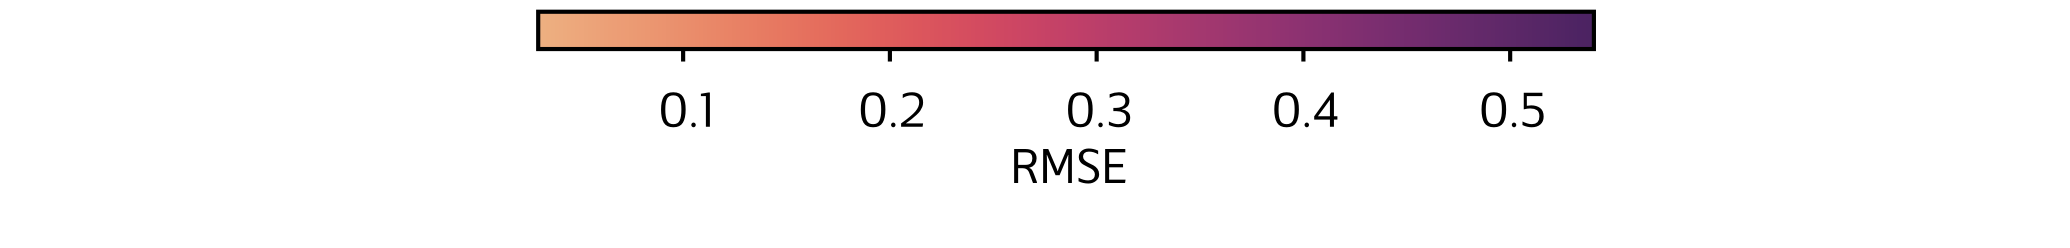

Saving fig_S8B__invisible_parrot__legend in /home/john/projects/can-manuscript/fig_S8__dark_kudu/graphics: [.svg] [.png] done


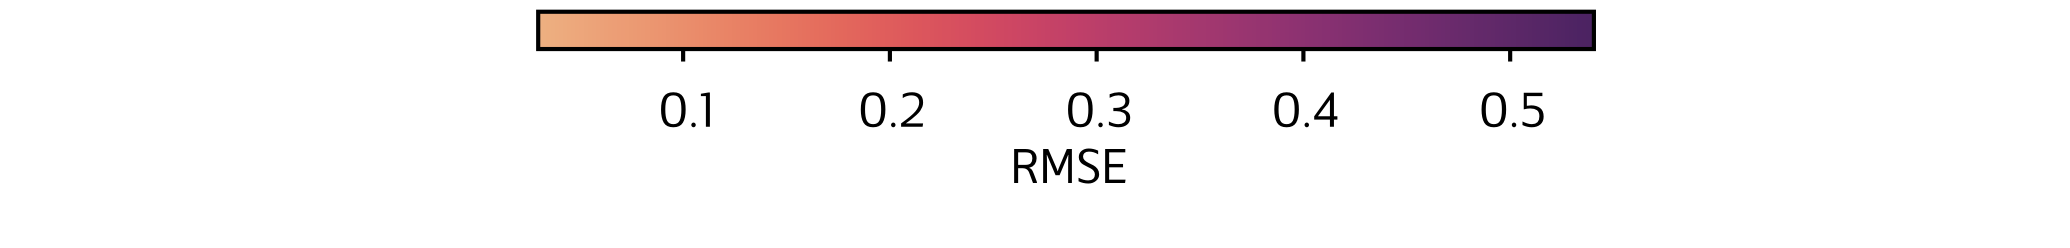

Saving fig_S8C__oblong_quetzal__legend in /home/john/projects/can-manuscript/fig_S8__dark_kudu/graphics: [.svg] [.png] done


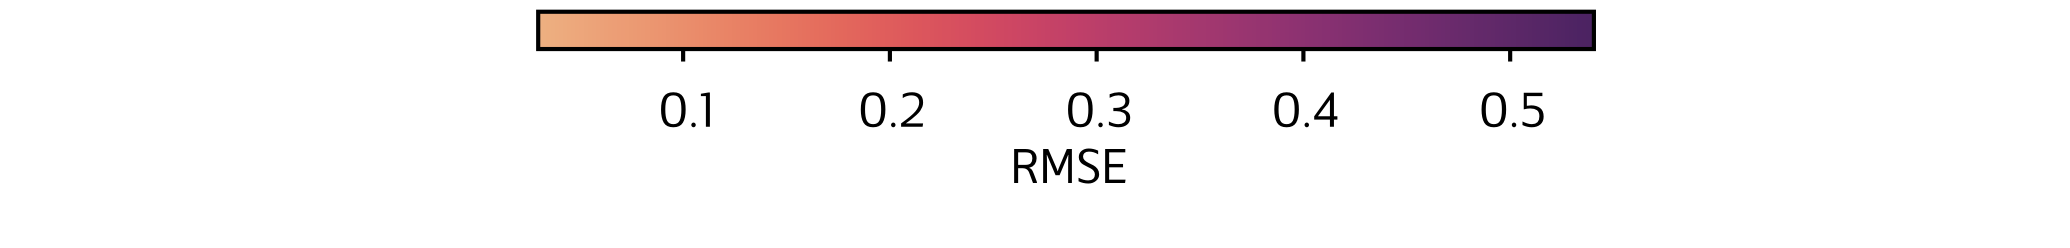

In [19]:
width = 3.45
height = 0.829 / 2
figsize = (width, height)
ticklabelsize = 6
labelsize = 6

fig = plt.figure()
fig.set_figwidth(width)
fig.set_figheight(height)

ax = plt.axes([0.26, 0.8, 0.51, 0.15])

# Dummy data for the colorbar
dummy_data = np.array([0, 1])
# norm = mpl.colors.Normalize(vmin=all_rmses.min(), vmax=all_rmses.max())

# Create a ScalarMappable object
sm = plt.cm.ScalarMappable(cmap=cmap, norm=rmse_norm)
sm.set_array([])  # You have to set a dummy array for ScalarMappable

# Add the colorbar to the specified axes
cbar = fig.colorbar(
    sm, cax=ax, orientation="horizontal", shrink=0.6, aspect=20, pad=0.5
)

cbar.ax.tick_params(labelsize=ticklabelsize, width=0.5, length=1.5)
cbar.set_label("RMSE", fontsize=labelsize, labelpad=1)

savefig(plt.gcf(), alias="tangible_urchin", extra="legend")
savefig(plt.gcf(), alias="invisible_parrot", extra="legend")
savefig(plt.gcf(), alias="oblong_quetzal", extra="legend")